# Install Libraries

In [1]:
#Install the necessary libraries for forecasting
!pip install statsforecast mlforecast neuralforecast nixtla -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.7/314.7 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.2/71.2 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.8/254.8 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.5/273.5 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Importing Libraries Required for this Notebook

In [2]:
!pip install xgboost -q

In [3]:
from nixtla import NixtlaClient
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsforecast import StatsForecast
from statsforecast.models import AutoTBATS, AutoARIMA, AutoETS
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from numba import njit
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from mlforecast.target_transforms import AutoDifferences
from neuralforecast import NeuralForecast
from neuralforecast.models import TFT, NHITS
from neuralforecast.losses.pytorch import MAE
from nixtla import NixtlaClient
from functools import reduce
#import timesfm

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Data Preparation

In [96]:
data = pd.read_excel("weekly_data.xlsx")

In [97]:
data.head()

date warehouse  orders                    holiday_name  holiday  \
0 2020-12-06  Prague_1   13479                               0        0   
1 2020-12-13  Prague_1   49517                               0        0   
2 2020-12-20  Prague_1   53288                               0        0   
3 2020-12-27  Prague_1   45261  Christmas Eve2nd Christmas Day        2   
4 2021-01-03  Prague_1   45811                   New Years Day        1   

   shutdown  mini_shutdown  shops_closed  winter_school_holidays  \
0         0              0             0                       0   
1         0              0             0                       0   
2         0              0             0                       0   
3         0              0             1                       0   
4         0              0             1                       0   

   school_holidays  blackout  mov_change  frankfurt_shutdown  precipitation  \
0                0         0           0                   0            0.0   
1                0         0           0                   0            1.3   
2                0         0           0                   0            0.0   
3                0         0           0                   0            7.0   
4                0         0           0                   0            1.0   

   snow  user_activity_1  user_activity_2  \
0   0.0             3410            65082   
1   0.0            11976           227222   
2   0.0            12429           227107   
3   0.0            10738           193645   
4   0.0            11916           220659   

                                                  id  
0             Prague_1_2020-12-05Prague_1_2020-12-06  
1  Prague_1_2020-12-07Prague_1_2020-12-08Prague_1...  
2  Prague_1_2020-12-14Prague_1_2020-12-15Prague_1...  
3  Prague_1_2020-12-21Prague_1_2020-12-22Prague_1...  
4  Prague_1_2020-12-28Prague_1_2020-12-29Prague_1...

In [98]:
data.columns

Index(['date', 'warehouse', 'orders', 'holiday_name', 'holiday', 'shutdown',
       'mini_shutdown', 'shops_closed', 'winter_school_holidays',
       'school_holidays', 'blackout', 'mov_change', 'frankfurt_shutdown',
       'precipitation', 'snow', 'user_activity_1', 'user_activity_2', 'id'],
      dtype='object')

## Dropping the columns that wont be known in advance.

In [99]:
data = data.drop(["holiday_name", 'shutdown', 'mini_shutdown', 'blackout', 'frankfurt_shutdown', "id", 'blackout', 'mov_change', 'frankfurt_shutdown','precipitation', 'snow', 'user_activity_1', 'user_activity_2'], axis=1)

In [100]:
#rename as per requirement of the forecast libraries
data = data.rename(columns={"warehouse": "unique_id", "date": "ds", "orders": "y"})

In [101]:
data.head()

ds unique_id      y  holiday  shops_closed  winter_school_holidays  \
0 2020-12-06  Prague_1  13479        0             0                       0   
1 2020-12-13  Prague_1  49517        0             0                       0   
2 2020-12-20  Prague_1  53288        0             0                       0   
3 2020-12-27  Prague_1  45261        2             1                       0   
4 2021-01-03  Prague_1  45811        1             1                       0   

   school_holidays  
0                0  
1                0  
2                0  
3                0  
4                0

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688 entries, 0 to 687
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ds                      688 non-null    datetime64[ns]
 1   unique_id               688 non-null    object        
 2   y                       688 non-null    int64         
 3   holiday                 688 non-null    int64         
 4   shops_closed            688 non-null    int64         
 5   winter_school_holidays  688 non-null    int64         
 6   school_holidays         688 non-null    int64         
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 37.8+ KB


In [11]:
data['ds'] = pd.to_datetime(data['ds'])

In [102]:
#Splitting the Data for Train & Test
train = data[data['ds'] <= '2023-05-14']
test = data[data['ds'] > '2023-05-14']

In [103]:
train.groupby('unique_id')['y'].count()

unique_id
Brno_1      128
Prague_1    128
Prague_2    128
Prague_3    128
Name: y, dtype: int64

In [104]:
train.head()

ds unique_id      y  holiday  shops_closed  winter_school_holidays  \
0 2020-12-06  Prague_1  13479        0             0                       0   
1 2020-12-13  Prague_1  49517        0             0                       0   
2 2020-12-20  Prague_1  53288        0             0                       0   
3 2020-12-27  Prague_1  45261        2             1                       0   
4 2021-01-03  Prague_1  45811        1             1                       0   

   school_holidays  
0                0  
1                0  
2                0  
3                0  
4                0

# SFFORECAST

###Defining Statforecast Parameters

In [15]:
models = [AutoARIMA(season_length=12)]

sf = StatsForecast(models=models, freq='W', n_jobs=1)

In [16]:
test_ = test.drop("y", axis=1)

In [17]:
horizon = 44
sf_fcst = sf.forecast(df=train, h=horizon, X_df=test_, level=(5,10,20,30,40,50,60,70,80,90,95))

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:494: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [18]:
sf_fcst.head()

ds     AutoARIMA  AutoARIMA-lo-95  AutoARIMA-lo-90  \
unique_id                                                              
Brno_1    2023-05-21  54021.949219     47267.585938     48353.507812   
Brno_1    2023-05-28  54021.949219     44469.835938     46005.562500   
Brno_1    2023-06-04  54021.949219     42323.046875     44203.921875   
Brno_1    2023-06-11  54021.949219     40513.218750     42685.066406   
Brno_1    2023-06-18  54021.949219     38918.730469     41346.929688   

           AutoARIMA-lo-80  AutoARIMA-lo-70  AutoARIMA-lo-60  AutoARIMA-lo-50  \
unique_id                                                                       
Brno_1        49605.507812     50450.226562     51121.582031     51697.546875   
Brno_1        47776.156250     48970.769531     49920.210938     50734.746094   
Brno_1        46372.449219     47835.542969     48998.367188     49995.964844   
Brno_1        45189.066406     46878.503906     48221.214844     49373.140625   
Brno_1        44146.484375     46035.332031     47536.531250     48824.421875   

           AutoARIMA-lo-40  AutoARIMA-lo-30  ...  AutoARIMA-hi-10  \
unique_id                                    ...                    
Brno_1        52214.777344     52694.070312  ...     54455.000000   
Brno_1        51466.222656     52144.046875  ...     54634.375000   
Brno_1        50891.835938     51721.996094  ...     54772.015625   
Brno_1        50407.605469     51366.191406  ...     54888.050781   
Brno_1        49980.992188     51052.722656  ...     54990.281250   

           AutoARIMA-hi-20  AutoARIMA-hi-30  AutoARIMA-hi-40  AutoARIMA-hi-50  \
unique_id                                                                       
Brno_1        54895.027344     55349.832031     55829.125000     56346.355469   
Brno_1        55256.667969     55899.855469     56577.679688     57309.156250   
Brno_1        55534.164062     56321.906250     57152.066406     58047.937500   
Brno_1        55768.105469     56677.710938     57636.296875     58670.761719   
Brno_1        55974.210938     56991.179688     58062.910156     59219.480469   

           AutoARIMA-hi-60  AutoARIMA-hi-70  AutoARIMA-hi-80  AutoARIMA-hi-90  \
unique_id                                                                       
Brno_1        56922.320312     57593.675781     58438.394531     59690.394531   
Brno_1        58123.691406     59073.132812     60267.742188     62038.339844   
Brno_1        59045.535156     60208.359375     61671.453125     63839.980469   
Brno_1        59822.687500     61165.398438     62854.835938     65358.835938   
Brno_1        60507.371094     62008.570312     63897.417969     66696.976562   

           AutoARIMA-hi-95  
unique_id                   
Brno_1        60776.316406  
Brno_1        63574.066406  
Brno_1        65720.859375  
Brno_1        67530.679688  
Brno_1        69125.171875  

[5 rows x 24 columns]

### Defining AutoTBATS & AutoETS

In [19]:
models = [AutoTBATS(season_length=12),AutoETS(season_length=12)]

In [20]:
stat_fcst = StatsForecast(models=models,freq='W')

In [21]:
train_stat_df_ETS_TBATS = train[["unique_id", "ds", "y"]]

In [22]:
ets_tbats = stat_fcst.forecast(df=train_stat_df_ETS_TBATS, h=44, level=(5,10,20,30,40,50,60,70,80,90,95))

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:494: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [23]:
ets_tbats.head()

ds     AutoTBATS  AutoTBATS-lo-5  AutoTBATS-lo-10  \
unique_id                                                             
Brno_1    2023-05-21  51155.406250    50952.472656     50748.738281   
Brno_1    2023-05-28  50962.066406    50748.484375     50534.058594   
Brno_1    2023-06-04  50988.960938    50764.257812     50538.667969   
Brno_1    2023-06-11  51233.378906    50997.238281     50760.164062   
Brno_1    2023-06-18  51633.734375    51385.960938     51137.207031   

           AutoTBATS-lo-20  AutoTBATS-lo-30  AutoTBATS-lo-40  AutoTBATS-lo-50  \
unique_id                                                                       
Brno_1        50335.519531     49908.421875     49458.328125     48972.605469   
Brno_1        50099.156250     49649.652344     49175.941406     48664.730469   
Brno_1        50081.121094     49608.210938     49109.835938     48572.007812   
Brno_1        50279.324219     49782.335938     49258.589844     48693.382812   
Brno_1        50632.679688     50111.210938     49561.660156     48968.609375   

           AutoTBATS-lo-60  AutoTBATS-lo-70  ...  AutoETS-hi-10  \
unique_id                                    ...                  
Brno_1        48431.730469     47801.273438  ...   53003.464844   
Brno_1        48095.476562     47431.941406  ...   53068.144531   
Brno_1        47973.113281     47275.027344  ...   53124.406250   
Brno_1        48064.000000     47330.375000  ...   53174.867188   
Brno_1        48308.222656     47538.457031  ...   53221.015625   

           AutoETS-hi-20  AutoETS-hi-30  AutoETS-hi-40  AutoETS-hi-50  \
unique_id                                                               
Brno_1      53380.253906   53769.695312   54180.109375   54623.011719   
Brno_1      53510.511719   53967.726562   54449.566406   54969.546875   
Brno_1      53623.820312   54140.000000   54683.980469   55271.015625   
Brno_1      53725.457031   54294.531250   54894.253906   55541.445312   
Brno_1      53818.417969   54435.882812   55086.593750   55788.816406   

           AutoETS-hi-60  AutoETS-hi-70  AutoETS-hi-80  AutoETS-hi-90  \
unique_id                                                               
Brno_1      55116.203125   55691.078125   56414.402344   57486.476562   
Brno_1      55548.570312   56223.492188   57072.699219   58331.347656   
Brno_1      55924.710938   56686.671875   57645.390625   59066.359375   
Brno_1      56262.125000   57102.167969   58159.128906   59725.710938   
Brno_1      56570.769531   57482.238281   58629.070312   60328.847656   

           AutoETS-hi-95  
unique_id                 
Brno_1      58416.343750  
Brno_1      59423.042969  
Brno_1      60298.835938  
Brno_1      61084.480469  
Brno_1      61803.152344  

[5 rows x 47 columns]

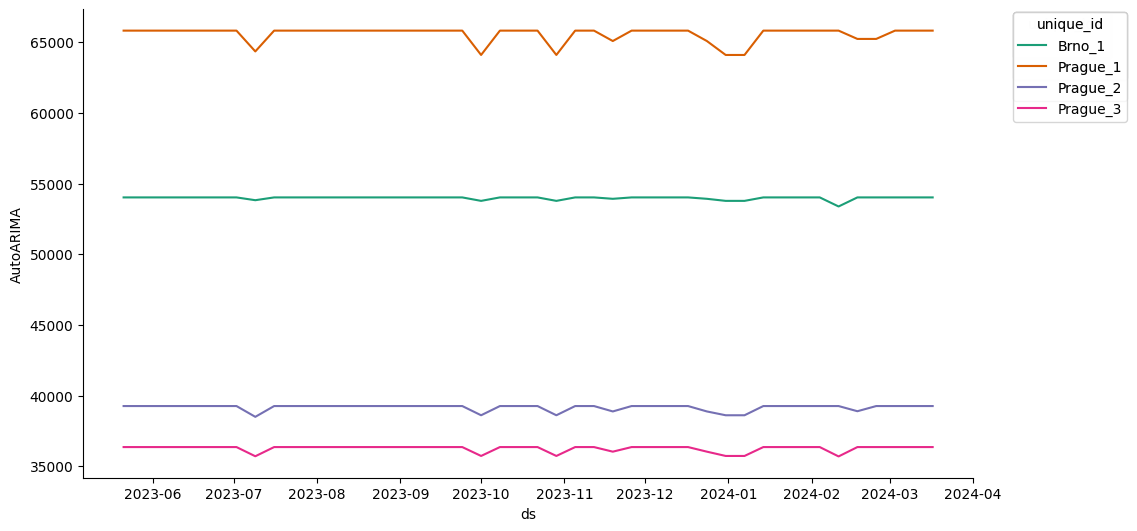

In [24]:
# @title ds vs AutoARIMA

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ds']
  ys = series['AutoARIMA']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = sf_fcst.sort_values('ds', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('unique_id')):
  _plot_series(series, series_name, i)
  fig.legend(title='unique_id', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ds')
_ = plt.ylabel('AutoARIMA')

# MLForecast

In [32]:
sf_fcst.to_csv("sf_forecast_weekly_merged.csv")
ets_tbats.to_csv("ets_tbats_forecast_weekly_merged.csv")

In [34]:

from google.colab import files
files.download("sf_forecast_weekly_merged.csv")
files.download("ets_tbats_forecast_weekly_merged.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [128]:
models = [LinearRegression(),
    lgb.LGBMRegressor(verbosity=-1),
    xgb.XGBRegressor(),
    RandomForestRegressor(random_state=0),
]
@njit
def rolling_mean_4(x):
    return rolling_mean(x, window_size=4)
@njit
def rolling_mean_13(x):
    return rolling_mean(x, window_size=13)

mlf = MLForecast(
    models=models,
    freq='W',
    lags=[1,4,13,26],

    lag_transforms={
        1: [expanding_mean],
       4: [rolling_mean_4, rolling_mean_13],
        13: [rolling_mean_4, rolling_mean_13],
        26: [rolling_mean_4, rolling_mean_13],
        52: [rolling_mean_4, rolling_mean_13],
    },
    date_features=['year', 'month', 'day', 'quarter'],
    target_transforms=[AutoDifferences(max_diffs=2)])


In [129]:
from mlforecast.utils import PredictionIntervals

In [130]:
train

ds unique_id      y  holiday  shops_closed  \
0   2020-12-06  Prague_1  13479        0             0   
1   2020-12-13  Prague_1  49517        0             0   
2   2020-12-20  Prague_1  53288        0             0   
3   2020-12-27  Prague_1  45261        2             1   
4   2021-01-03  Prague_1  45811        1             1   
..         ...       ...    ...      ...           ...   
639 2023-04-16    Brno_1  51340        1             1   
640 2023-04-23    Brno_1  51150        0             0   
641 2023-04-30    Brno_1  51683        0             0   
642 2023-05-07    Brno_1  50302        1             0   
643 2023-05-14    Brno_1  53777        1             1   

     winter_school_holidays  school_holidays  
0                         0                0  
1                         0                0  
2                         0                0  
3                         0                0  
4                         0                0  
..                      ...              ...  
639                       0                0  
640                       0                0  
641                       0                0  
642                       0                0  
643                       0                0  

[512 rows x 7 columns]

In [131]:
mlf.fit(
    train,
    id_col='unique_id',
    time_col='ds',
    target_col='y',
    static_features=[],
    prediction_intervals=PredictionIntervals(n_windows=2, h=44),
)

MLForecast(models=[LinearRegression, LGBMRegressor, XGBRegressor, RandomForestRegressor], freq=W, lag_features=['lag1', 'lag4', 'lag13', 'lag26', 'expanding_mean_lag1', 'rolling_mean_4_lag4', 'rolling_mean_13_lag4', 'rolling_mean_4_lag13', 'rolling_mean_13_lag13'], date_features=['year', 'month', 'day', 'quarter'], num_threads=1)

In [132]:
#For using in predict function
future_df = test[["unique_id", "ds", 'holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays']]

In [134]:
levels=[5,10,20,30,40,50,60,70,80,90,95]

In [135]:
mlforecast = mlf.predict(h=44, X_df=future_df, level=levels)

In [136]:
mlforecast.head()

unique_id         ds  LinearRegression  LGBMRegressor  XGBRegressor  \
0    Brno_1 2023-05-21      52761.230469   52547.792969  52520.937500   
1    Brno_1 2023-05-28      52618.945312   52336.414062  52851.566406   
2    Brno_1 2023-06-04      53323.253906   52806.445312  52488.191406   
3    Brno_1 2023-06-11      53038.941406   53225.093750  53569.750000   
4    Brno_1 2023-06-18      53456.707031   54206.015625  54576.636719   

   RandomForestRegressor  LinearRegression-lo-95  LinearRegression-lo-90  \
0           52956.500000            51927.864258            51994.470703   
1           52840.949219            52004.489844            52029.764844   
2           52455.300781            49289.784766            49504.253125   
3           53192.121094            45954.689551            46501.652539   
4           53482.449219            43076.983691            43610.354102   

   LinearRegression-lo-80  LinearRegression-lo-70  ...  \
0            52127.683594            52260.896484  ...   
1            52080.314844            52130.864844  ...   
2            49933.189844            50362.126563  ...   
3            47595.578516            48689.504492  ...   
4            44677.094922            45743.835742  ...   

   RandomForestRegressor-hi-10  RandomForestRegressor-hi-20  \
0                 52972.109375                 52987.718750   
1                 53863.147656                 54885.346094   
2                 53556.337109                 54657.373437   
3                 54760.469531                 56328.817969   
4                 54818.343359                 56154.237500   

   RandomForestRegressor-hi-30  RandomForestRegressor-hi-40  \
0                 53003.328125                 55575.134375   
1                 55907.544531                 61060.057031   
2                 55758.409766                 63755.471484   
3                 57897.166406                 68683.686719   
4                 57490.131641                 71066.164453   

   RandomForestRegressor-hi-50  RandomForestRegressor-hi-60  \
0                 59425.039062                 63274.943750   
1                 68277.726562                 75495.396094   
2                 75200.545898                 86645.620313   
3                 84079.292969                 99474.899219   
4                 90762.266602                110458.368750   

   RandomForestRegressor-hi-70  RandomForestRegressor-hi-80  \
0                 67124.848437                 70974.753125   
1                 82713.065625                 89930.735156   
2                 98090.694727                109535.769141   
3                114870.505469                130266.111719   
4                130154.470898                149850.573047   

   RandomForestRegressor-hi-90  RandomForestRegressor-hi-95  
0                 74824.657812                 76749.610156  
1                 97148.404687                100757.239453  
2                120980.843555                126703.380762  
3                145661.717969                153359.521094  
4                169546.675195                179394.726270  

[5 rows x 94 columns]

# Neural Forecast

In [87]:
hist_exog_list = ['holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays']
levels = [5,10,20,30,40,50,60,70,80,90,95]
horizon = 44  # Number of future time steps to predict
from neuralforecast.losses.pytorch import MQLoss
# Initialize the TFT model
tft_model = TFT(h=44,
                input_size=88,
                hist_exog_list=hist_exog_list,loss=MQLoss(level=levels),
                max_steps=200,
                start_padding_enabled=True)

# Initialize the NHITS model
nhits_model = NHITS(h=44,
                input_size=88,
                hist_exog_list=hist_exog_list,loss=MQLoss(level=levels),
                max_steps=200,
                start_padding_enabled=True)

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1


In [88]:
nf = NeuralForecast(models=[tft_model, nhits_model], freq='W')

nf.fit(df=train)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MQLoss                   | 23     | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 1.5 K  | train
4 | temporal_encoder        | TemporalCovariateEncoder | 948 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MQLoss        | 23     | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 3.9 M  | train
-------------------------------------------------------
3.9 M     Trainable params
23        Non-trainable params
3.9 M     Total params
15.440    Total estimated model params size (MB)
34        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.


In [36]:
neural_fcst = nf.predict(futr_df = future_df)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [89]:
neural_fcst.head()

ds    TFT-median     TFT-lo-90     TFT-lo-80     TFT-hi-80  \
unique_id                                                                      
Brno_1    2023-05-21  52925.574219  51234.234375  51649.609375  54314.937500   
Brno_1    2023-05-28  52744.039062  51077.406250  51457.949219  54166.609375   
Brno_1    2023-06-04  52723.171875  51025.027344  51409.093750  54182.710938   
Brno_1    2023-06-11  52609.726562  50982.226562  51346.832031  54059.718750   
Brno_1    2023-06-18  52437.492188  50979.894531  51311.925781  53817.082031   

              TFT-hi-90  NHITS-median   NHITS-lo-95   NHITS-lo-90  \
unique_id                                                           
Brno_1     54552.761719  53760.566406  51862.371094  52378.117188   
Brno_1     54433.960938  53600.570312  51323.839844  52010.152344   
Brno_1     54455.675781  54153.839844  51620.746094  51965.328125   
Brno_1     54345.437500  54355.089844  51519.289062  52103.785156   
Brno_1     54107.531250  54649.976562  52091.582031  52613.328125   

            NHITS-lo-80  ...   NHITS-hi-10   NHITS-hi-20   NHITS-hi-30  \
unique_id                ...                                             
Brno_1     52671.707031  ...  53855.820312  54332.800781  54395.445312   
Brno_1     52594.628906  ...  53832.800781  54347.289062  54504.457031   
Brno_1     52614.503906  ...  54747.953125  54632.175781  54719.363281   
Brno_1     52900.339844  ...  54990.398438  54902.015625  55083.664062   
Brno_1     52975.484375  ...  55289.128906  55245.253906  55186.324219   

            NHITS-hi-40   NHITS-hi-50   NHITS-hi-60   NHITS-hi-70  \
unique_id                                                           
Brno_1     54298.894531  54662.960938  54997.558594  55560.191406   
Brno_1     54594.003906  55090.718750  55627.015625  55976.281250   
Brno_1     55100.210938  55366.093750  55750.398438  55992.246094   
Brno_1     55436.359375  55585.218750  55887.632812  55998.449219   
Brno_1     55629.234375  55724.789062  56067.175781  56374.500000   

            NHITS-hi-80   NHITS-hi-90   NHITS-hi-95  
unique_id                                            
Brno_1     55795.566406  56685.027344  57296.660156  
Brno_1     56021.636719  56758.843750  57119.945312  
Brno_1     56719.761719  57393.500000  57818.449219  
Brno_1     56729.179688  57185.273438  57328.484375  
Brno_1     56995.167969  57351.082031  58145.433594  

[5 rows x 29 columns]

In [38]:

neural_fcst.to_csv("neural_forecast_weekly_merged.csv")

In [39]:

from google.colab import files

files.download("neural_forecast_weekly_merged.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# TimeGPT

In [40]:

# Initialize the NixtlaClient
nixtla_client = NixtlaClient(api_key='nixak-dZyIsJpKaqa6jjcPkhMCcHNI6S9heGWdO5iG2WixOCViM5afbymNqIRgE1XZHgkTx7MhzC9lhzFz4eKm')

# Assuming df is your input dataframe with historical data
# and future_df is your dataframe with future exogenous variables

# Specify the exogenous variables
exog_vars = ['holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays']
# Make the forecast
timegpt_fcst_zero = nixtla_client.forecast(df=train, h=44, X_df=future_df, freq='W', level=(5,10,20,30,40,50,60,70,80,90,95))


In [41]:
timegpt_fcst_zero['ds'] = pd.to_datetime(timegpt_fcst_zero['ds'])

In [42]:
timegpt_fcst_zero.head()

unique_id         ds    TimeGPT  TimeGPT-hi-10  TimeGPT-hi-20  \
0    Brno_1 2023-05-21  50947.640      51064.348      51179.760   
1    Brno_1 2023-05-28  50373.836      50975.100      51178.605   
2    Brno_1 2023-06-04  50199.540      51030.780      51623.450   
3    Brno_1 2023-06-11  50015.566      50286.242      50609.113   
4    Brno_1 2023-06-18  49981.720      50468.690      51029.082   

   TimeGPT-hi-30  TimeGPT-hi-40  TimeGPT-hi-5  TimeGPT-hi-50  TimeGPT-hi-60  \
0      51598.484      51630.613     51041.710      52159.880      52785.008   
1      51385.230      51462.010     50814.895      52193.970      52564.120   
2      52321.617      52401.227     50714.188      52419.246      53587.504   
3      50628.266      50703.490     50099.547      50977.492      51579.324   
4      51481.043      52208.836     50185.973      52793.062      53044.773   

   ...  TimeGPT-lo-20  TimeGPT-lo-30  TimeGPT-lo-40  TimeGPT-lo-5  \
0  ...      50715.520      50296.797      50264.668     50853.570   
1  ...      49569.066      49362.440      49285.660     49932.777   
2  ...      48775.630      48077.460      47997.850     49684.890   
3  ...      49422.020      49402.867      49327.645     49931.586   
4  ...      48934.355      48482.395      47754.600     49777.465   

   TimeGPT-lo-50  TimeGPT-lo-60  TimeGPT-lo-70  TimeGPT-lo-80  TimeGPT-lo-90  \
0      49735.402      49110.273      48768.773      48609.207      48352.297   
1      48553.703      48183.550      47873.960      47588.652      47462.938   
2      47979.832      46811.574      46031.027      45937.625      45610.246   
3      49053.640      48451.810      47045.047      45713.050      45564.188   
4      47170.375      46918.664      46099.168      45073.620      44845.730   

   TimeGPT-lo-95  
0      48343.777  
1      47187.260  
2      45270.850  
3      45347.242  
4      44818.910  

[5 rows x 25 columns]

## Timesfm

In [ ]:
# Y_test_df = test.copy()
# df = train.copy()

In [ ]:
# tfm = timesfm.TimesFm(
#     context_len=512,
#     horizon_len=8,
#     input_patch_len=32,
#     output_patch_len=128,
#     num_layers=20,
#     model_dims=1280,
#     backend="cpu",
# )
# tfm.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")

In [ ]:
# timesfm_df = tfm.forecast_on_df(
#     inputs=df,
#     freq='MS',
#     value_name='y',
#     num_jobs=-1,
# )

In [46]:
timesfm_df = pd.read_csv("timesfm_weekly.csv")

In [47]:
timesfm_df['ds'] = pd.to_datetime(timesfm_df['ds'])

In [48]:
timegpt_fcst_zero.head()

unique_id         ds    TimeGPT  TimeGPT-hi-10  TimeGPT-hi-20  \
0    Brno_1 2023-05-21  50947.640      51064.348      51179.760   
1    Brno_1 2023-05-28  50373.836      50975.100      51178.605   
2    Brno_1 2023-06-04  50199.540      51030.780      51623.450   
3    Brno_1 2023-06-11  50015.566      50286.242      50609.113   
4    Brno_1 2023-06-18  49981.720      50468.690      51029.082   

   TimeGPT-hi-30  TimeGPT-hi-40  TimeGPT-hi-5  TimeGPT-hi-50  TimeGPT-hi-60  \
0      51598.484      51630.613     51041.710      52159.880      52785.008   
1      51385.230      51462.010     50814.895      52193.970      52564.120   
2      52321.617      52401.227     50714.188      52419.246      53587.504   
3      50628.266      50703.490     50099.547      50977.492      51579.324   
4      51481.043      52208.836     50185.973      52793.062      53044.773   

   ...  TimeGPT-lo-20  TimeGPT-lo-30  TimeGPT-lo-40  TimeGPT-lo-5  \
0  ...      50715.520      50296.797      50264.668     50853.570   
1  ...      49569.066      49362.440      49285.660     49932.777   
2  ...      48775.630      48077.460      47997.850     49684.890   
3  ...      49422.020      49402.867      49327.645     49931.586   
4  ...      48934.355      48482.395      47754.600     49777.465   

   TimeGPT-lo-50  TimeGPT-lo-60  TimeGPT-lo-70  TimeGPT-lo-80  TimeGPT-lo-90  \
0      49735.402      49110.273      48768.773      48609.207      48352.297   
1      48553.703      48183.550      47873.960      47588.652      47462.938   
2      47979.832      46811.574      46031.027      45937.625      45610.246   
3      49053.640      48451.810      47045.047      45713.050      45564.188   
4      47170.375      46918.664      46099.168      45073.620      44845.730   

   TimeGPT-lo-95  
0      48343.777  
1      47187.260  
2      45270.850  
3      45347.242  
4      44818.910  

[5 rows x 25 columns]

In [49]:
# Make the forecast with timegpt finetuned
timegpt_fcst_finetune_4 = nixtla_client.forecast(df=train, h=44, X_df=future_df, freq='W', finetune_steps=4, level=(5,10,20,30,40,50,60,70,80,90,95))

In [50]:
timegpt_fcst_finetune_6 = nixtla_client.forecast(df=train, h=44, X_df=future_df, freq='W', finetune_steps=6, level=(5,10,20,30,40,50,60,70,80,90,95))

In [51]:
timegpt_fcst_finetune_8= nixtla_client.forecast(df=train, h=44, X_df=future_df, freq='W', finetune_steps=8, level=(5,10,20,30,40,50,60,70,80,90,95))

In [52]:
timegpt_fcst_finetune_6.rename(columns={'TimeGPT': 'TimeGPT_6'}, inplace=True)

In [53]:
timegpt_fcst_finetune_4.rename(columns={'TimeGPT': 'TimeGPT_4'}, inplace=True)

In [54]:
timegpt_fcst_finetune_8.rename(columns={'TimeGPT': 'TimeGPT_8'}, inplace=True)

In [59]:
timegpt_fcst_finetune_4.columns = ['TimeGPT_4-' + str(col) if 'TimeGPT-' in str(col) else col for col in timegpt_fcst_finetune_4.columns]
timegpt_fcst_finetune_6.columns = ['TimeGPT_6-' + str(col) if 'TimeGPT-' in str(col) else col for col in timegpt_fcst_finetune_6.columns]






In [60]:


timegpt_fcst_finetune_8.columns = ['TimeGPT_8-' + str(col) if 'TimeGPT-' in str(col) else col for col in timegpt_fcst_finetune_8.columns]

In [55]:
timesfm_df = pd.read_csv("timesfm_weekly.csv")

In [56]:

timesfm_df['ds'] = pd.to_datetime(timesfm_df['ds'])

In [137]:
#Merge All Results
data_frames = [sf_fcst, ets_tbats,mlforecast, neural_fcst,timegpt_fcst_zero,timegpt_fcst_finetune_4, timegpt_fcst_finetune_6, timegpt_fcst_finetune_8, timesfm_df ]
final_forecast_monthly_merged = reduce(lambda  left,right: pd.merge(left,right,on=['unique_id', 'ds'],how='inner'), data_frames)

In [138]:
final_forecast_monthly_merged.to_csv("final_forecast_weekly_merged.csv")

In [139]:
# prompt: write code to download final_forecast_weekly_merged.csv to local

from google.colab import files
files.download('final_forecast_weekly_merged.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>